In [110]:
import cv2
import numpy as np
from imutils import paths
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from matplotlib import pyplot as plt
from tqdm import tqdm


In [111]:
class BatchGenerator(Sequence):
    def __init__(self, path, batch_size, image_size=(60,80), gray_scale=True):
        self._batch_size = batch_size
        images = list(paths.list_images(path))
        self._images_path = images[:int(len(images)*0.7)]
        self._image_size = image_size
        self._gray_scale = gray_scale

    def __len__(self):
        return int(np.ceil(len(self._images_path) / self._batch_size))

    def __getitem__(self, idx):
        l_bound = idx * self._batch_size
        r_bound = (idx + 1) * self._batch_size

        if r_bound > len(self._images_path):
            r_bound = len(self._images_path)
            l_bound = r_bound - self._batch_size

        instance_count = 0
        x_batch = np.zeros((r_bound - l_bound, self._image_size[1], self._image_size[0], 1 if self._gray_scale else 3))

        for instance_count, train_instance in enumerate(self._images_path[l_bound:r_bound]):
            image = cv2.imread(train_instance)
            image = cv2.resize(image, self._image_size)
            if self._gray_scale:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = image[..., np.newaxis]
            image = image / 255
            x_batch[instance_count] = image

        return x_batch, x_batch

    def on_epoch_end(self):
        np.random.shuffle(self._images_path)

In [112]:
train_generator = BatchGenerator("./GM-Closed/GM-Closed-Approve", 8)
val_generator = BatchGenerator("./GM-Closed/GM-Closed-Approve", 8)

In [113]:
input_img = keras.Input(shape=(80, 60, 1))

x = layers.Conv2D(32, (2, 2), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (2, 2), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((5, 5), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((5, 5))(x)
x = layers.Conv2D(16, (2, 2), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (2, 2), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [114]:
MODEL_NAME = "anomaly_detector"
best_loss_model_name = f"{MODEL_NAME}_best_loss.h5"
check_point_saver_best_loss = ModelCheckpoint(best_loss_model_name, monitor='val_loss', verbose=1,
                                              save_best_only=True, save_weights_only=False, mode='auto',
                                              period=1)

In [115]:
autoencoder.fit(train_generator, validation_data=val_generator, epochs=200, callbacks=[check_point_saver_best_loss])

Epoch 1/200
54/54 [==============================] - ETA: 0s - loss: 0.6304
Epoch 1: val_loss improved from inf to 0.56816, saving model to anomaly_detector_best_loss.h5
54/54 [==============================] - 10s 175ms/step - loss: 0.6304 - val_loss: 0.5682
Epoch 2/200
54/54 [==============================] - ETA: 0s - loss: 0.5592
Epoch 2: val_loss improved from 0.56816 to 0.55298, saving model to anomaly_detector_best_loss.h5
54/54 [==============================] - 9s 175ms/step - loss: 0.5592 - val_loss: 0.5530
Epoch 3/200
54/54 [==============================] - ETA: 0s - loss: 0.5503
Epoch 3: val_loss improved from 0.55298 to 0.54782, saving model to anomaly_detector_best_loss.h5
54/54 [==============================] - 9s 159ms/step - loss: 0.5503 - val_loss: 0.5478
Epoch 4/200
54/54 [==============================] - ETA: 0s - loss: 0.5464
Epoch 4: val_loss improved from 0.54782 to 0.54492, saving model to anomaly_detector_best_loss.h5
54/54 [==============================] -

KeyboardInterrupt: 

In [116]:
autoencoder = load_model(best_loss_model_name)

1/1 [==============================] - 0s 111ms/step


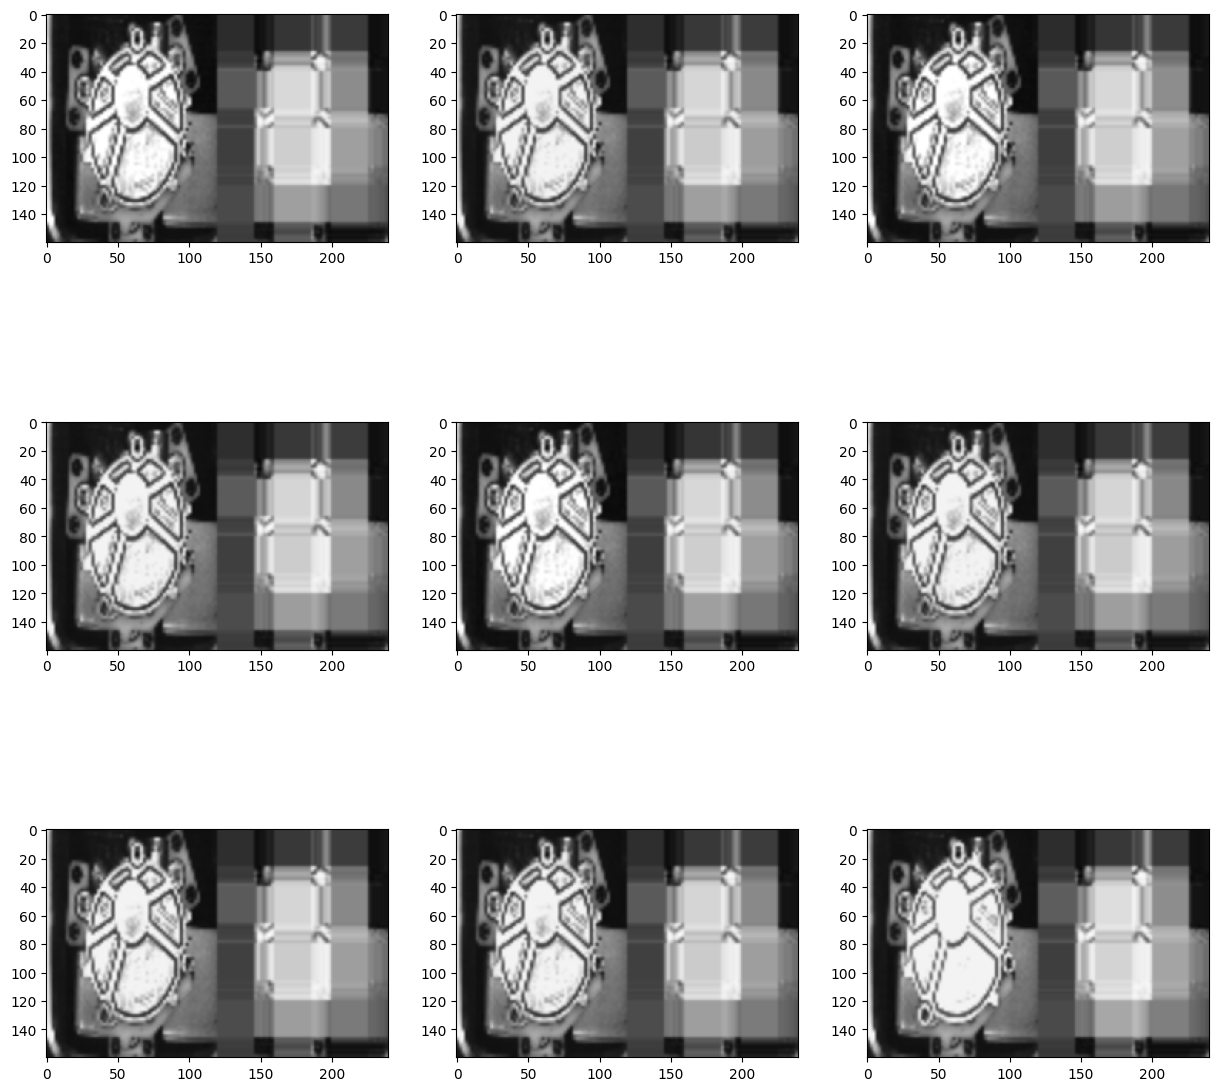

In [118]:
plt.figure(figsize=(15,15))
test_generator = BatchGenerator("./GM-Closed/GM-Closed-Reprove/", 9)

# batch = next(test_generator)
batch = next(iter(test_generator))[0]

preds = autoencoder.predict(batch)
for i, (gt, pred) in enumerate(zip(batch, preds)):
    plt.subplot(3,3,i+1)
    
    gt = np.uint8(gt * 255)
    pred = np.uint8(pred * 255)
    concat = cv2.hconcat([gt, pred])
    concat = cv2.resize(concat, None, fx=2, fy=2)
    plt.imshow(cv2.cvtColor(concat, cv2.COLOR_GRAY2RGB))
plt.show()